## Debug make_lerobot_dataset_with_episodes()

### Quick Start

1. **Point to a training output directory** that contains `train_pipeline_config.yaml`
2. **Update the path** in the cell below
3. **Run all cells** to load the config and test the dataset creation

### What this notebook does

- Loads the saved training config from a previous run
- Reconstructs a `TrainPipelineConfig` object
- Tests `make_lerobot_dataset_with_episodes()` with sample episodes
- Shows you the dataset structure and sample data


In [ ]:
import sys
from pathlib import Path
import yaml

# Add the necessary paths
sys.path.insert(0, str(Path.cwd().parent.parent.parent / "third_party" / "lerobot" / "src"))

# Import the types that are in the YAML file so yaml.load can reconstruct them
from lerobot.configs.types import FeatureType, NormalizationMode
from lerobot.configs.train import TrainPipelineConfig


In [10]:
# Specify the path to your training output directory
training_output_dir = Path("/home/melon/sherry/so101_bench/outputs/2025-09-14_smolvla")

# The config file path
config_path = training_output_dir / "train_pipeline_config.yaml"

if config_path.exists():
    print(f"Found config at: {config_path}")
else:
    print(f"Config not found at {config_path}")
    print("Please update the training_output_dir path above")


Found config at: /home/melon/sherry/so101_bench/outputs/2025-09-14_smolvla/train_pipeline_config.yaml


In [13]:
# Load the YAML config with unsafe_load to handle all Python objects
# This is safe here because we trust the config file we created
with open(config_path, 'r') as f:
    config_dict = yaml.unsafe_load(f)

print("Loaded config from:", config_path)
print("\nConfig keys:", list(config_dict.keys()))


Loaded config from: /home/melon/sherry/so101_bench/outputs/2025-09-14_smolvla/train_pipeline_config.yaml

Config keys: ['batch_size', 'dataset', 'env', 'eval', 'eval_freq', 'job_name', 'log_freq', 'num_workers', 'optimizer', 'output_dir', 'policy', 'resume', 'save_checkpoint', 'save_freq', 'scheduler', 'seed', 'steps', 'use_policy_training_preset', 'wandb']


In [ ]:
# View the dataset and policy config
print("Dataset config:")
print(yaml.dump(config_dict.get('dataset', {}), default_flow_style=False, indent=2))

print("\n" + "="*80 + "\n")

print("Policy config (subset of fields):")
policy_config = config_dict.get('policy', {})
relevant_keys = ['type', 'n_obs_steps', 'chunk_size', 'n_action_steps', 'input_features', 'output_features']
for key in relevant_keys:
    if key in policy_config:
        print(f"  {key}: {policy_config[key]}")


Dataset config:
episodes: null
image_transforms:
  enable: false
  max_num_transforms: 3
  random_order: false
  tfs:
    brightness:
      kwargs:
        brightness:
        - 0.8
        - 1.2
      type: ColorJitter
      weight: 1.0
    contrast:
      kwargs:
        contrast:
        - 0.8
        - 1.2
      type: ColorJitter
      weight: 1.0
    hue:
      kwargs:
        hue:
        - -0.05
        - 0.05
      type: ColorJitter
      weight: 1.0
    saturation:
      kwargs:
        saturation:
        - 0.5
        - 1.5
      type: ColorJitter
      weight: 1.0
    sharpness:
      kwargs:
        sharpness:
        - 0.5
        - 1.5
      type: SharpnessJitter
      weight: 1.0
raw_dataset_root: /home/melon/sherry/so101_bench/datasets/recordings/
repo_id: sherryxychen/2025-09-01_pick-and-place-block
revision: null
root: null
use_imagenet_stats: true
video_backend: torchcodec



Policy config (subset of fields):
  type: smolvla
  n_obs_steps: 1
  chunk_size: 50
  n_act

In [ ]:
del config_dict['wandb']['log_loss_dict']

In [ ]:
# Reconstruct the TrainPipelineConfig from the loaded dict
import draccus
import json
import tempfile

# draccus expects JSON format, so we convert via a temp file
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    json.dump(config_dict, f, indent=2, default=str)
    temp_config_path = f.name

try:
    with draccus.config_type("json"):
        cfg = draccus.parse(TrainPipelineConfig, temp_config_path, args=[])
    
    print("✓ Successfully reconstructed TrainPipelineConfig")
    print(f"  Dataset repo_id: {cfg.dataset.repo_id}")
    print(f"  Dataset root: {cfg.dataset.root}")
    print(f"  Dataset raw_dataset_root: {cfg.dataset.raw_dataset_root}")
    print(f"  Policy type: {cfg.policy.type if cfg.policy else 'None'}")
    print(f"  Policy n_obs_steps: {cfg.policy.n_obs_steps if cfg.policy else 'None'}")
    print(f"  Policy chunk_size: {cfg.policy.chunk_size if cfg.policy else 'None'}")
finally:
    Path(temp_config_path).unlink()


✓ Successfully reconstructed TrainPipelineConfig
  Dataset repo_id: sherryxychen/2025-09-01_pick-and-place-block
  Dataset root: None
  Dataset raw_dataset_root: /home/melon/sherry/so101_bench/datasets/recordings/
  Policy type: smolvla
  Policy n_obs_steps: 1
  Policy chunk_size: 50


In [ ]:
# Import the function we want to debug
sys.path.insert(0, str(Path.cwd().parent))

from scripts.train.train import make_lerobot_dataset_with_episodes
from scripts.train.train import load_splits_yaml, get_episode_indices_from_names

# Load splits if raw_dataset_root is available
if cfg.dataset.raw_dataset_root:
    dataset_name = cfg.dataset.repo_id.split('/')[-1]
    raw_dataset_dir = Path(cfg.dataset.raw_dataset_root) / dataset_name
    
    if (raw_dataset_dir / "splits.yaml").exists():
        splits = load_splits_yaml(raw_dataset_dir)
        
        train_episode_names = splits.get('train', [])
        val_episode_names = splits.get('val_id', [])
        
        train_episodes = get_episode_indices_from_names(train_episode_names)
        val_episodes = get_episode_indices_from_names(val_episode_names)
        
        print(f"Found splits:")
        print(f"  Train episodes ({len(train_episodes)}): {train_episodes[:5]}...") if len(train_episodes) > 5 else print(f"  Train episodes: {train_episodes}")
        print(f"  Val episodes ({len(val_episodes)}): {val_episodes[:5]}...") if len(val_episodes) > 5 else print(f"  Val episodes: {val_episodes}")
    else:
        print(f"No splits.yaml found at {raw_dataset_dir / 'splits.yaml'}")
        train_episodes = None
else:
    print("No raw_dataset_root configured")
    train_episodes = None


Found splits:
  Train episodes (126): [0, 1, 2, 3, 4]...
  Val episodes (10): [60, 61, 62, 63, 64]...


In [ ]:
# Create the dataset with the test episodes
try:
    dataset = make_lerobot_dataset_with_episodes(cfg, val_episodes)
    print(f"\n✓ Successfully created dataset!")
    print(f"  Number of episodes: {dataset.num_episodes}")
    print(f"  Number of frames: {dataset.num_frames}")
    print(f"  Episode indices: {dataset.episodes}")
    print(f"  Video backend: {dataset.video_backend}")
except Exception as e:
    print(f"\n✗ Error creating dataset:")
    print(f"  {type(e).__name__}: {e}")
    import traceback
    traceback.print_exc()



✓ Successfully created dataset!
  Number of episodes: 10
  Number of frames: 7319
  Episode indices: [60, 61, 62, 63, 64, 65, 66, 67, 70, 71]
  Video backend: torchcodec


In [ ]:
print(dataset.episode_data_index["from"])
print(dataset.episode_data_index["to"])
print(dataset.meta.episodes[61]["length"])
print(dataset.delta_indices)
item = dataset[2]
item.keys()

print(item["timestamp"])
print(item["episode_index"])
print(item["frame_index"])

tensor([   0,  696, 1465, 2203, 2918, 3671, 4364, 5072, 5773, 6666])
tensor([ 696, 1465, 2203, 2918, 3671, 4364, 5072, 5773, 6666, 7319])
769
{'action': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'observation.state': [0], 'observation.images.cam_front': [0], 'observation.images.cam_top': [0]}
tensor(0.0667)
tensor(60)
tensor(2)


In [ ]:
episode_indices = set()
for i in range(dataset.num_frames):
    episode_indices.add(dataset[i]["episode_index"].item())

print(episode_indices)





{64, 65, 66, 67, 70, 71, 60, 61, 62, 63}


## Visualize joint trajectory

In [ ]:
from pathlib import Path

dataset_dir = Path("/home/melon/sherry/so101_bench/datasets/recordings/eval_2025-09-14_smolvla_ood")
episode_name = "2025-09-01_pick-and-place-block__068_2025-09-04_20-39-48__eval__010_2025-09-16_22-02-57"

import pandas as pd

def load_jsonl_pandas(file_path):
    df = pd.read_json(file_path, lines=True)
    return df

sync_logs_df = load_jsonl_pandas(dataset_dir / "episodes" / episode_name /'sync_logs.jsonl')
sync_logs_df.head()

follower_traj_df = load_jsonl_pandas(dataset_dir / "episodes" / episode_name / "obs" / "follower_trajectory.jsonl")
follower_traj_df.head()

leader_traj_df = load_jsonl_pandas(dataset_dir / "episodes" / episode_name / "obs" / "leader_trajectory.jsonl")
leader_traj_df.head()



,sequence_number,timestamp,shoulder_pan.pos,shoulder_lift.pos,elbow_flex.pos,wrist_flex.pos,wrist_roll.pos,gripper.pos
0,1,2025-09-17 05:02:57.577260971,8.741522,-98.803419,99.274705,76.182137,-48.614741,1.480385
1,2,2025-09-17 05:02:57.591734171,8.741522,-98.803419,99.274705,76.182137,-48.614741,1.480385
2,3,2025-09-17 05:02:57.626360655,8.741522,-98.803419,99.274705,76.182137,-48.614741,1.480385
3,4,2025-09-17 05:02:57.660084963,8.741522,-98.290598,99.184044,76.094571,-48.562467,1.480385
4,5,2025-09-17 05:02:57.691118002,8.816880,-96.923077,98.096102,76.007005,-48.562467,1.554404


In [12]:
# Calculate timestamp spread (max - min) across all timestamp sources
def calculate_timestamp_spread_ms(row):
    timestamps = [
        row['robot_state_timestamp'],
        row['action_timestamp'],
        row['camera_timestamps']['cam_front'],
        row['camera_timestamps']['cam_top']
    ]
    return (max(timestamps) - min(timestamps)) * 1000

sync_logs_df['timestamp_spread_ms'] = sync_logs_df.apply(calculate_timestamp_spread_ms, axis=1)

# Display some statistics
print(f"Timestamp spread statistics (seconds):")
print(f"  Mean: {sync_logs_df['timestamp_spread_ms'].mean():.6f}")
print(f"  Median: {sync_logs_df['timestamp_spread_ms'].median():.6f}")
print(f"  Max: {sync_logs_df['timestamp_spread_ms'].max():.6f}")
print(f"  Min: {sync_logs_df['timestamp_spread_ms'].min():.6f}")

sync_logs_df.head()


Timestamp spread statistics (seconds):
  Mean: 64.172482
  Median: 63.611269
  Max: 257.714510
  Min: 45.131207


,sequence_number,timestamp,robot_state_timestamp,camera_timestamps,action_timestamp,timestamp_spread,timestamp_spread_ms
0,1,2025-09-17 05:02:57.379226208,1.758085e+09,"{'cam_front': 1758085377.3195465, 'cam_top': 1...",1.758085e+09,0.257715,257.714510
1,2,2025-09-17 05:02:57.583858967,1.758085e+09,"{'cam_front': 1758085377.551604, 'cam_top': 17...",1.758085e+09,0.047569,47.568798
2,3,2025-09-17 05:02:57.617257833,1.758085e+09,"{'cam_front': 1758085377.58365, 'cam_top': 175...",1.758085e+09,0.050220,50.219536
3,4,2025-09-17 05:02:57.650657654,1.758085e+09,"{'cam_front': 1758085377.619677, 'cam_top': 17...",1.758085e+09,0.047807,47.806740
4,5,2025-09-17 05:02:57.684056520,1.758085e+09,"{'cam_front': 1758085377.6517184, 'cam_top': 1...",1.758085e+09,0.046840,46.839714


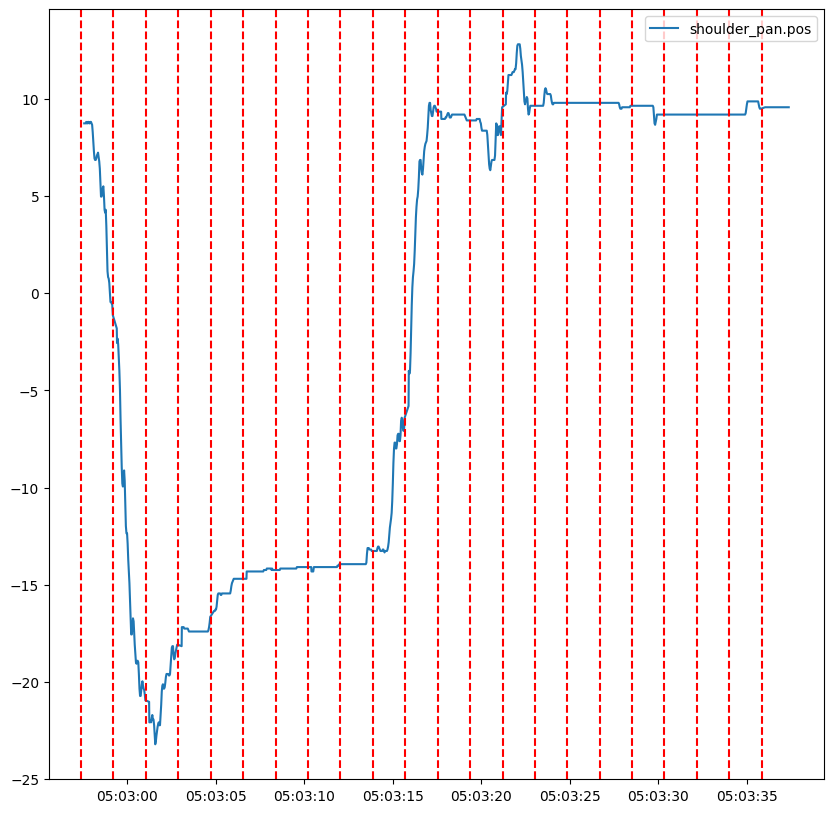

In [15]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.plot(leader_traj_df["timestamp"], leader_traj_df["shoulder_pan.pos"], label="shoulder_pan.pos")
# plt.plot(follower_traj_df["timestamp"], follower_traj_df["shoulder_pan.pos"], label="follower_shoulder_pan.pos")
for row in sync_logs_df.itertuples():
    if row.timestamp_spread_ms > 200:
        plt.axvline(x=row.timestamp, color='red', linestyle='--')
plt.legend()
plt.show()




Timestamp spread statistics (seconds):
  Mean: 64.172482
  Median: 63.611269
  Max: 257.714510
  Min: 45.131207


,sequence_number,timestamp_spread_ms
0,1,257.714510
1,2,47.568798
2,3,50.219536
3,4,47.806740
4,5,46.839714
